# Importing Libraries

In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Constants



In [434]:
# Data used for analysis
DATA='EURUSD'

# The events data prices before and after the event
HOURS_BEFORE=2
HOURS_AFTER=24

# price columns 
PRICE_COLUMNS = [str(num)+'h' for num in np.arange(-HOURS_BEFORE,HOURS_AFTER+1)]

# Predition columns
PREDICTED_FUTURE_PRICES = ['1h','3h','5h']

# PRICES TO DROP WHICH WE DONT NEED
PRICES_TO_DROP = PRICE_COLUMNS.copy()
for price in PREDICTED_FUTURE_PRICES:
    PRICES_TO_DROP.remove(price)
PRICES_TO_DROP.remove('0h')

# Events information columns
EVENT_COLUMNS = ['time','currency','description','impact','actual','deviation','consensus','previous','result']

# Since we already have extracted the meaning of this columns in the result we are discarding this columns
EVENT_COLUMNS_DROP = ['actual','deviation','consensus','previous']

# IMPACT COLORS to visualize
IMPACT_COLORS = {
    'low': '#F5C861',
    'medium': '#E4871B',
    'high': '#D25746',
    'none': 'black'
}

NULL_COLUMNS = []

FEATURES_INFO = {
    'time' : 'Time of event occuring',
    'currency': 'Currencies might be affected',
    'description' : 'Event Information',
    'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
    'actual': 'Actual Value when event occured',
    'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
    'consensus': 'It is a general agreement of experts on the outcome of the number.',
    'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
    'result' : 'Green: better than expected Red: worse than expected, Black : neutral'
}
for item in PRICE_COLUMNS:
    if item.startswith('-') or item.startswith('0h'):
        FEATURES_INFO[item] = 'Price before ' + item + ' of the event'
    else:
        FEATURES_INFO[item] = 'Price after ' + item + ' of the event'

In [435]:
EVENT_COLUMNS

['time',
 'currency',
 'description',
 'impact',
 'actual',
 'deviation',
 'consensus',
 'previous',
 'result']

In [436]:
PRICE_COLUMNS

['-2h',
 '-1h',
 '0h',
 '1h',
 '2h',
 '3h',
 '4h',
 '5h',
 '6h',
 '7h',
 '8h',
 '9h',
 '10h',
 '11h',
 '12h',
 '13h',
 '14h',
 '15h',
 '16h',
 '17h',
 '18h',
 '19h',
 '20h',
 '21h',
 '22h',
 '23h',
 '24h']

# Load Data

In [437]:
# Load the data according to the currency
frame = pd.read_csv('./data/events_'+DATA+'.csv',index_col=['time'],header=0)
# frame = pd.read_csv('./data/economic_events_'+DATA+'.csv',index_col=['time'],header=0)

# Convert the time string to datetime object
frame.index = pd.to_datetime(frame.index,format='%Y-%m-%d %H:%M:%S%z',utc=True)

# hex color actual colum contains the result : positive-green, negative - red, black-neutral
frame.rename(columns={'hex_color_actual':'result'},inplace=True)
type(frame.index)
frame.attrs['features'] = FEATURES_INFO
# Create MultiIndex
# frame['time'] = pd.to_datetime(frame['time'],format='%Y-%m-%d %H:%M:%S%z',utc=True)
# frame.set_index(['time','currency','description'])


# EDA

In [438]:
# Shape of the dataset
frame.shape

(29709, 35)

In [439]:
# Info about the dataset
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29709 entries, 2013-01-02 09:13:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     29709 non-null  object 
 1   description  29709 non-null  object 
 2   impact       29709 non-null  object 
 3   actual       29709 non-null  object 
 4   deviation    29709 non-null  object 
 5   consensus    29709 non-null  object 
 6   previous     29709 non-null  object 
 7   result       29709 non-null  object 
 8   -2h          29703 non-null  float64
 9   -1h          29704 non-null  float64
 10  0h           29698 non-null  float64
 11  1h           29664 non-null  float64
 12  2h           29604 non-null  float64
 13  3h           29578 non-null  float64
 14  4h           29567 non-null  float64
 15  5h           29545 non-null  float64
 16  6h           29183 non-null  float64
 17  7h           28877 non-null  float64
 18 

In [440]:
# Basic Stats
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
-2h,29703.0,1.153155,0.090889,0.95555,1.090870,1.127860,1.188330,1.39562
-1h,29704.0,1.153137,0.090908,0.95388,1.090830,1.127810,1.188560,1.39629
0h,29698.0,1.153080,0.090889,0.95437,1.090830,1.127655,1.188522,1.39629
1h,29664.0,1.153028,0.090874,0.95558,1.091060,1.127410,1.188540,1.39629
2h,29604.0,1.152938,0.090899,0.95437,1.090910,1.127305,1.188382,1.39543
3h,29578.0,1.152854,0.090867,0.95739,1.090810,1.127230,1.188080,1.39543
4h,29567.0,1.152863,0.090825,0.95655,1.090870,1.127260,1.188240,1.39492
5h,29545.0,1.152857,0.090827,0.95845,1.090570,1.127230,1.188000,1.39492
6h,29183.0,1.153222,0.090979,0.95930,1.090750,1.127400,1.187990,1.39334
7h,28877.0,1.153185,0.090896,0.95811,1.091000,1.127430,1.187740,1.39339


In [441]:
# Colums in dataset
frame.columns

Index(['currency', 'description', 'impact', 'actual', 'deviation', 'consensus',
       'previous', 'result', '-2h', '-1h', '0h', '1h', '2h', '3h', '4h', '5h',
       '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
       '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h'],
      dtype='object')

In [442]:
# Head of the dataset
frame.head()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,-0.48,45.1,45.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,46.7,1.20,45.3,45.1,green,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,0.00,44.6,44.6,black,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46,-0.28,46.3,46.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46.1,-0.32,46.3,46.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147


In [443]:
# Last 10 rows of the dataset
frame.tail()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green,1.06967,1.07043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red,1.06967,1.07043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green,1.07043,1.06981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index(Jun),medium,68.2,0.63,65.8,65.6,green,1.06981,1.07179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation(Jun),medium,3%,-1.58,3.1%,3.1%,red,1.06981,1.07179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering

## Understanding the features

In [444]:
# Features Info
frame.attrs['features']

{'time': 'Time of event occuring',
 'currency': 'Currencies might be affected',
 'description': 'Event Information',
 'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
 'actual': 'Actual Value when event occured',
 'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
 'consensus': 'It is a general agreement of experts on the outcome of the number.',
 'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
 'result': 'Green: better than expected Red: worse than expected, Black : neutral

## Feature improvement

### Dropping off the unwanted columns

1. The values in the actual deviation consensus and preivous is in different format(%,Million, Billion,) and the information is already extracted by featching the result part in the dataframe so we dont need it.

In [445]:
frame.drop(columns=EVENT_COLUMNS_DROP,inplace=True)
for item in EVENT_COLUMNS_DROP:
    EVENT_COLUMNS.remove(item)

2. Since we are only planning to work with the PREDICTED_FUTURE_PRICES constant values we will drop another prices columns which we dont need  

In [446]:
frame.drop(PRICES_TO_DROP,axis=1,inplace=True)
PRICE_COLUMNS = PREDICTED_FUTURE_PRICES.copy()
PRICE_COLUMNS.append('0h')


### Missing values



It is a statistical technique of replacing missing data with substituted values. Once all missing values have been imputed, the data set can be analyzed using standard techniques. If **5% of data is missing, then it can be ignored** and if **60%-70% of the data is missing then it can be dropped(rule of thumb)**. 

**3 mechanisms of causes of missing data:** https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/

1. **Missing At Random(MAR):** When there is a systematic relation between inclination if missing values and the observed variable value.
2. **Missing Completely At Random(MCAR):** Where there is no relationship between the missingness of data in a variable with any values in any other variable.
3. **Missing Not At Random(MNAR):** The value of the variable that is missing based on the reason why the data was not provided like a person may not be interested to share the blood group.

**Mechanisms to impute missing data:**

**Single Imputation:** 
Used when only very little bit of data is missing. Each missing data is replaced with single value based on certain strategy.
1. **Summary statistics substitution:** Substitute the missing value of a variable by the statistical summary like mean, median of the observed value of that variable
2. **Regression Imputation:** Replace the missing value by regressing the missing variable on the other variable
Interpolation and extrapolation
3. **Model based imputation:** treat the variable with missing values as target variable and use machine learning algorithm to  predict the missing values.
 

**Multiple Imputation:** 
Used when the data is missing in random but not completely at random. Each missing value is replaced with multiple values based on the information in the portion of dataset. Multiple imputation is used to generate multiple datasets, perform statistical analysis on them, and average the results.
1. **Stochastic regression:** The predicted value of the missing data from the regression plus the residual error values.
Hot deck imputation: Randomly chosen value from an individual in the sample which has similar values on the other variables. Ex: If ‘age’ is a feature between only 5-10, then randomly missing values can be substituted between 5-10.

In [447]:
# Finding the null values in events colums which is having null value
print('Null values in %')
print()
for column in EVENT_COLUMNS[1:]:
    frame[column] = frame[column].replace('-', np.nan)
    print(column + ' :' + str(frame[column].isnull().mean()*100))
    if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)

for column in PRICE_COLUMNS:
     print(column + ' :' + str(frame[column].isnull().mean()*100))
     if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)


Null values in %

currency :0.0
description :0.0
impact :0.0
result :0.0
1h :0.1514692517418964
3h :0.4409438217375206
5h :0.5520212730149113
0h :0.03702581709246357


In [448]:
# Shape of the null values columns
for column in NULL_COLUMNS:
    print( column + ' : ' +  str(frame[frame[column].isnull()].shape))

# Frame rows/columns
frame.shape


1h : (45, 8)
3h : (131, 8)
5h : (164, 8)
0h : (11, 8)


(29709, 8)

In [449]:
for column in NULL_COLUMNS:
    print('Null column: *******' + column + '****** details')
    print(frame[frame[column].isnull()].tail(10))
    print()
    

Null column: *******1h****** details
                          currency                  description impact result  \
time                                                                            
2022-10-07 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low  green   
2022-11-20 10:00:00+00:00      EUR       Unemployment Rate(Oct)    low  green   
2023-04-07 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2023-05-05 19:00:00+00:00      USD  Consumer Credit Change(Mar)    low  green   
2023-09-08 19:00:00+00:00      USD  Consumer Credit Change(Jul)    low    red   
2023-10-06 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low    red   
2024-01-20 14:30:00+00:00      EUR       Unemployment Rate(Dec)    low    red   
2024-03-01 22:30:00+00:00      USD     Total Vehicle Sales(Jan)    low  green   
2024-04-05 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2024-06-07 19:00:00+00:00      USD  Consumer Credit Change(Apr)    low  

### Imputation

1. First we will check the events for which all the prices columns are null

In [450]:
# frame.drop(frame[PRICE_COLUMNS].isnull().all(axis=1),inplace=True)
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2020-05-15 20:00:00+00:00,USD,Total Net TIC Flows(Mar),low,green,NaN,NaN,NaN,NaN
2020-10-16 20:00:00+00:00,USD,Net Long-Term TIC Flows(Aug),low,green,NaN,NaN,NaN,NaN
2022-11-20 10:00:00+00:00,EUR,Unemployment Rate(Oct),low,green,NaN,NaN,NaN,NaN
2024-01-20 14:30:00+00:00,EUR,Unemployment Rate(Dec),low,red,NaN,NaN,NaN,NaN
2024-03-01 22:30:00+00:00,USD,Total Vehicle Sales(Jan),low,green,NaN,NaN,NaN,NaN


In [451]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].shape
# frame.loc[frame[PRICE_COLUMNS].isnull()].tail()

(9, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly friday/saturday. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there will be no impact of the event on the currency since the market is close


https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [452]:
frame.dropna(subset=PRICE_COLUMNS, how='all',inplace=True)

In [453]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)]

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,


2. We will now check the events for which any the prices columns are null

In [454]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].tail(10)

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2023-02-10 20:00:00+00:00,USD,Monthly Budget Statement(Jan),medium,green,1.06786,1.06783,NaN,NaN
2023-03-10 20:00:00+00:00,USD,Monthly Budget Statement(Feb),medium,red,1.06367,1.06382,NaN,NaN
2023-04-07 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,1.08962,NaN,NaN,NaN
2023-05-05 19:00:00+00:00,USD,Consumer Credit Change(Mar),low,green,1.10178,NaN,NaN,NaN
2023-09-08 19:00:00+00:00,USD,Consumer Credit Change(Jul),low,red,1.06971,NaN,NaN,NaN
2023-10-06 19:00:00+00:00,USD,Consumer Credit Change(Aug),low,red,1.05831,NaN,NaN,NaN
2023-10-20 18:00:00+00:00,USD,Monthly Budget Statement(Aug),medium,red,1.05918,1.05913,NaN,NaN
2024-04-05 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,1.08364,NaN,NaN,NaN
2024-05-10 18:00:00+00:00,USD,Monthly Budget Statement(Apr),medium,red,1.07714,1.07703,NaN,NaN


In [455]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].shape

(159, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly occured during the closing time of the market. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there is no data for the prices after the event
https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [456]:
frame.dropna(subset=PREDICTED_FUTURE_PRICES, how='any',inplace=True)

3.  Since we are going to predict based on the previous values. till 0h we need prices of till 0h to predict the future prices(1h,2h...)

In [457]:
hours = '0h'
frame.loc[frame[hours].isnull()].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2016-03-22 15:00:00+00:00,USD,Richmond Fed Manufacturing Index(Mar),low,green,NaN,1.12269,1.12202,1.12158
2016-10-13 14:30:00+00:00,USD,EIA Natural Gas Storage Change(Oct 7),low,green,NaN,1.10290,1.10400,1.10543


**Since we need the prvious values to forcast the future values(1h,3h,5h) and since we dont have much data to fullfill future values we are dropping the values**

In [458]:
frame.dropna(subset=hours,inplace=True)


In [459]:
frame.isnull().sum()

currency       0
description    0
impact         0
result         0
0h             0
1h             0
3h             0
5h             0
dtype: int64

In [460]:
frame.shape

(29539, 8)

In [461]:
frame.loc[:,:'0h']

,currency,description,impact,result,0h
time,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,red,1.32641
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,green,1.32641
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,black,1.32641
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,red,1.32641
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,red,1.32641
...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,green,1.06981
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,red,1.06981
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,green,1.07179


#### Time based features

In [462]:
# frame.index
frame['hour_of_day'] = frame.index.hour
frame['month_of_year'] = frame.index.month
frame['day_of_week'] = frame.index.dayofweek


In [464]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week'],
      dtype='object')



# Visualization

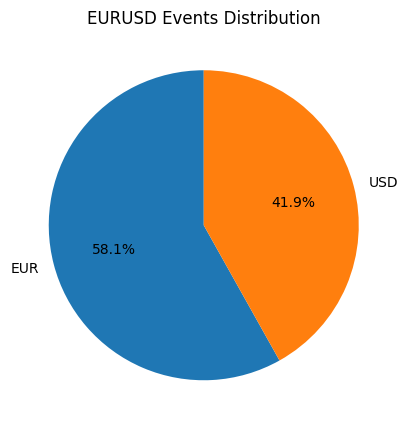

currency
EUR    17170
USD    12369
Name: count, dtype: int64

In [465]:
currency_row_count = frame['currency'].value_counts()
fig,ax = plt.subplots(figsize=(5,8))
ax.pie(currency_row_count, autopct='%1.1f%%', startangle=90,labels=currency_row_count.index)
ax.set_title(DATA + ' Events Distribution')
plt.show()
currency_row_count


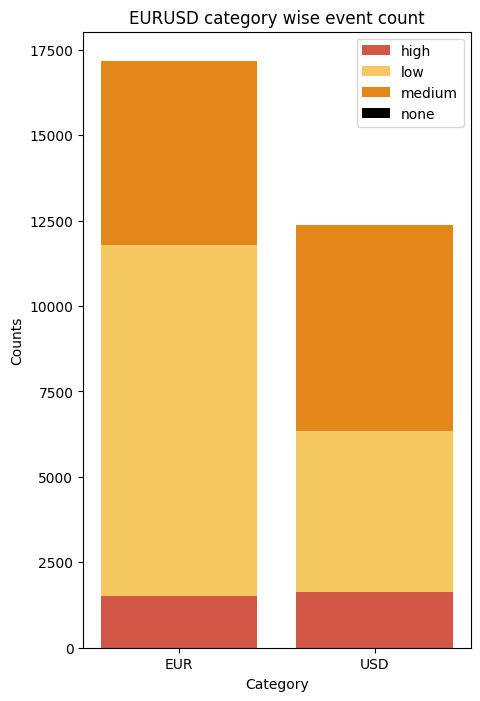

currency  impact
EUR       high       1524
          low       10274
          medium     5369
          none          3
USD       high       1632
          low        4715
          medium     6021
          none          1
Name: count, dtype: int64

In [466]:
currency_impact = frame[['currency','impact']].value_counts().sort_index()
currency_impact_count = frame.groupby(['currency','impact']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(5,8))
bottom = None
for impact in currency_impact_count.columns:
    if bottom is None:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
        bottom = currency_impact_count[impact]
    else:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
        bottom += currency_impact_count[impact]
ax.set_xlabel('Category')
ax.set_ylabel('Counts')
ax.legend()
ax.set_title( DATA + ' category wise event count')
plt.show()

# currency_impact_count
currency_impact

In [467]:
frame[frame['impact']=='none'].tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week
time,,,,,,,,,,,
2015-05-21 12:30:00+00:00,USD,Continuing Jobless Claims(May 8),none,green,1.11366,1.11127,1.11189,1.11323,12,5,3
2015-07-27 08:00:00+00:00,EUR,IFO – Business Climate(Jul),none,green,1.10868,1.10777,1.10671,1.10702,8,7,0
2015-07-27 08:00:00+00:00,EUR,IFO – Current Assessment(Jul),none,green,1.10868,1.10777,1.10671,1.10702,8,7,0
2015-07-27 08:00:00+00:00,EUR,IFO – Expectations(Jul),none,green,1.10868,1.10777,1.10671,1.10702,8,7,0


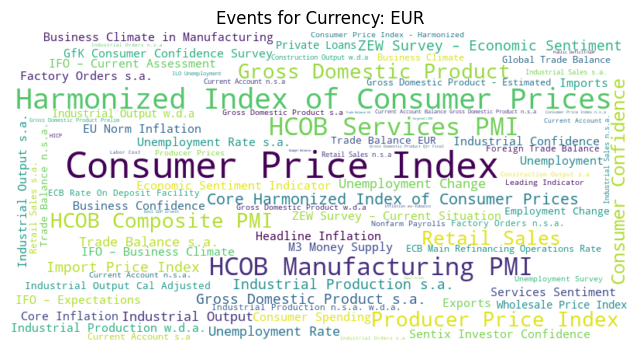

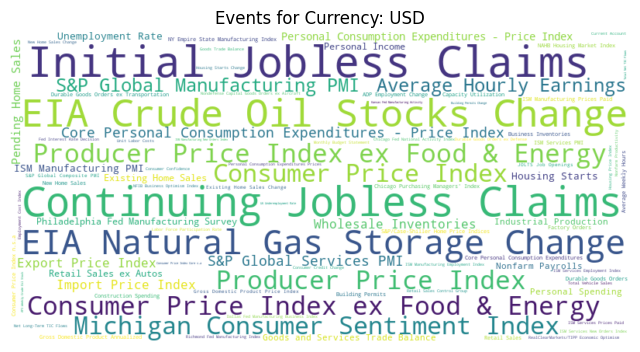

In [468]:
def process_description(description):
    if '(' in description:
        return description[:description.index('(')].strip()
    else:
        return description.strip()
for currency in frame['currency'].unique():
    # Filter descriptions for the current currency
    descriptions = frame[frame['currency'] == currency]['description'].apply(process_description).value_counts()
    d = dict(zip(descriptions.index,descriptions.values))
    # # Generate word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(d)
    # Plot the WordCloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Events for Currency: {currency}')
    plt.show()

In [469]:
pd.concat([frame['currency'],frame['description'].apply(process_description)], axis=1)[['currency','description']].value_counts().sort_values(ascending=False)

currency  description                        
EUR       Consumer Price Index                   2514
          Harmonized Index of Consumer Prices    1450
          HCOB Services PMI                      1095
          HCOB Manufacturing PMI                 1092
          HCOB Composite PMI                      670
                                                 ... 
          Manufacturing Output                      1
          9-Month Letras Auction                    1
USD       20-Year Bond Auction                      1
          4-Week Bill Auction                       1
EUR       3-Month Letras Auction                    1
Name: count, Length: 195, dtype: int64

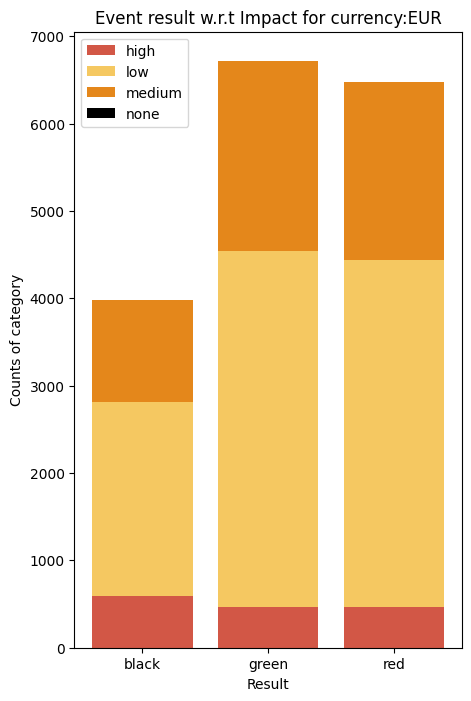

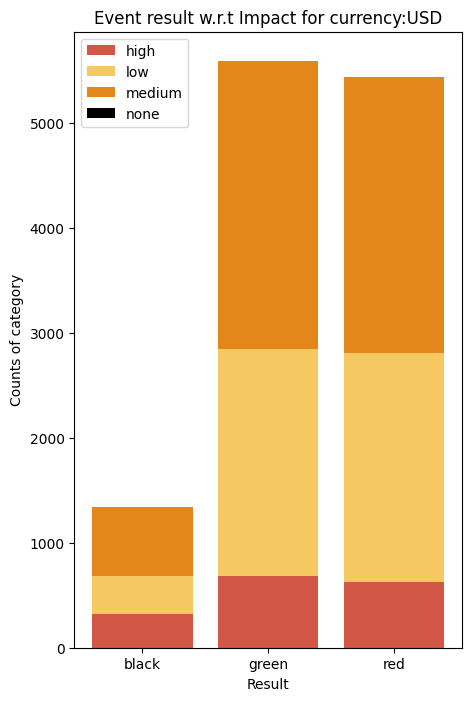

currency  impact  result
EUR       high    black      590
                  green      464
                  red        470
          low     black     2227
                  green     4075
                  red       3972
          medium  black     1158
                  green     2174
                  red       2037
          none    green        3
USD       high    black      324
                  green      685
                  red        623
          low     black      363
                  green     2163
                  red       2189
          medium  black      658
                  green     2741
                  red       2622
          none    green        1
Name: count, dtype: int64

In [470]:
for currency in frame['currency'].unique():
    subframe = frame[frame['currency'] == currency]
    # currency_impact = subframe[['impact','result']].value_counts()
    currency_impact_count = subframe.groupby(['result','impact']).size().unstack(fill_value=0)
    fig,ax = plt.subplots(figsize=(5,8))
    bottom = None
    for impact in currency_impact_count.columns:
        if bottom is None:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
            bottom = currency_impact_count[impact]
        else:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
            bottom += currency_impact_count[impact]
    ax.set_xlabel('Result')
    ax.set_ylabel('Counts of category')
    ax.legend()
    ax.set_title('Event result w.r.t Impact for currency:' + currency)
    plt.show()

    currency_impact_count
    currency_impact
frame[['currency','impact','result']].value_counts().sort_index()

In [471]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week'],
      dtype='object')

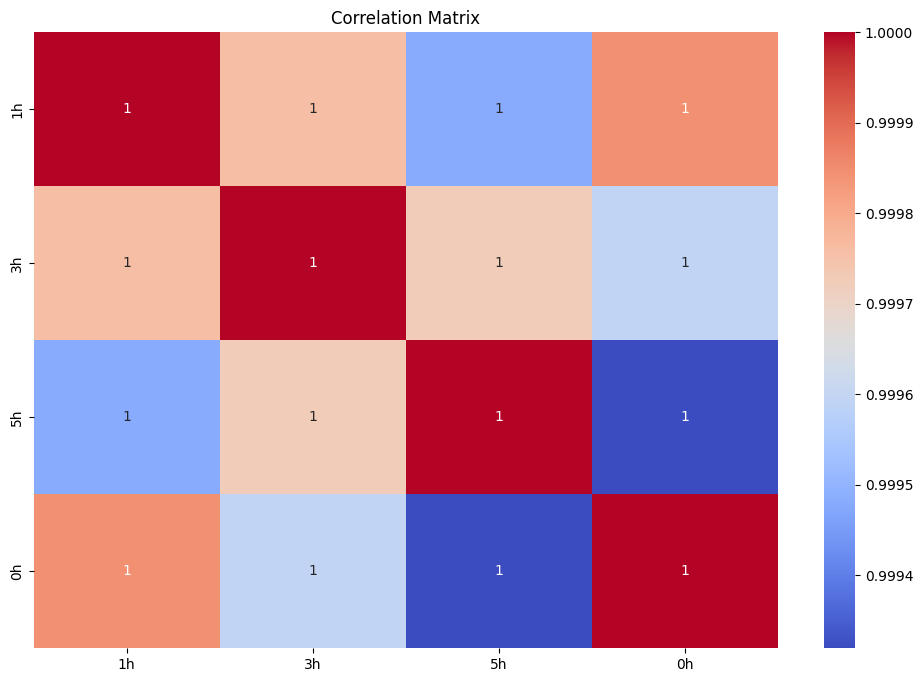

In [472]:
#Visualize the correlation matrix
prices_columns = PREDICTED_FUTURE_PRICES.copy()
prices_columns.append('0h')
plt.figure(figsize=(12, 8))
correlation_matrix = frame[prices_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



#### Encoder

In [477]:
len(frame.description.unique())

3828

In [478]:
EVENT_COLUMNS

['time', 'currency', 'description', 'impact', 'result']

In [479]:
labelencoder = LabelEncoder()
for i in EVENT_COLUMNS[1:]:
    # print(frame.loc[:,i])
    frame[i] = labelencoder.fit_transform(frame[i])

In [480]:
frame.description.max()

3827

### Encoding the columns

In [481]:
columns = frame.columns.values.tolist()
for item in PREDICTED_FUTURE_PRICES:
    columns.remove(item)
columns

['currency',
 'description',
 'impact',
 'result',
 '0h',
 'hour_of_day',
 'month_of_year',
 'day_of_week']

In [482]:

features = frame[columns] # Add more features as needed
target_1h = frame['1h']
target_3h = frame['3h']
target_5h = frame['5h']

# Split data into training and testing sets
X_train, X_test, y_train_1h, y_test_1h = train_test_split(features, target_1h, test_size=0.2, random_state=42)
_, _, y_train_3h, y_test_3h = train_test_split(features, target_3h, test_size=0.2, random_state=42)
_, _, y_train_5h, y_test_5h = train_test_split(features, target_5h, test_size=0.2, random_state=42)

In [483]:
# Calculate accuracy metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def print_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'{label} - R^2: {r2}')
    print(f'{label} - Mean Absolute Error (MAE): {mae}')
    print(f'{label} - Mean Squared Error (MSE): {mse}')
    print(f'{label} - Root Mean Squared Error (RMSE): {rmse}')
    print('-------------------------------------------')

In [484]:
from sklearn.linear_model import LinearRegression

# Train a Linear Regression model for each target
model_1h = LinearRegression()
model_3h = LinearRegression()
model_5h = LinearRegression()

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

print_metrics(y_test_1h,y_pred_1h,'1h')
print_metrics(y_test_3h,y_pred_3h,'3h')
print_metrics(y_test_5h,y_pred_5h,'5h')

1h - R^2: 0.9996867732134493
1h - Mean Absolute Error (MAE): 0.001091155233817004
1h - Mean Squared Error (MSE): 2.571183849757892e-06
1h - Root Mean Squared Error (RMSE): 0.0016034911442717394
-------------------------------------------
3h - R^2: 0.999203457228571
3h - Mean Absolute Error (MAE): 0.0018310757690513583
3h - Mean Squared Error (MSE): 6.540782953215605e-06
3h - Root Mean Squared Error (RMSE): 0.0025574954453948897
-------------------------------------------
5h - R^2: 0.9986659503550058
5h - Mean Absolute Error (MAE): 0.0024041979442869983
5h - Mean Squared Error (MSE): 1.0946138747966278e-05
5h - Root Mean Squared Error (RMSE): 0.0033084949369715346
-------------------------------------------


In [485]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree model for each target
model_1h = DecisionTreeRegressor(random_state=42)
model_3h = DecisionTreeRegressor(random_state=42)
model_5h = DecisionTreeRegressor(random_state=42)

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

print_metrics(y_test_1h,y_pred_1h,'1h')
print_metrics(y_test_3h,y_pred_3h,'3h')
print_metrics(y_test_5h,y_pred_5h,'5h')


1h - R^2: 0.9998213886361526
1h - Mean Absolute Error (MAE): 0.00046335985104942987
1h - Mean Squared Error (MSE): 1.4661666046039324e-06
1h - Root Mean Squared Error (RMSE): 0.0012108536677088327
-------------------------------------------
3h - R^2: 0.9995857787096106
3h - Mean Absolute Error (MAE): 0.0007396157752200444
3h - Mean Squared Error (MSE): 3.4013635578876126e-06
3h - Root Mean Squared Error (RMSE): 0.0018442786009406531
-------------------------------------------
5h - R^2: 0.9993625864252655
5h - Mean Absolute Error (MAE): 0.0009144075829383924
5h - Mean Squared Error (MSE): 5.230103283683146e-06
5h - Root Mean Squared Error (RMSE): 0.002286941906495035
-------------------------------------------


In [486]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model for each target
model_1h = RandomForestRegressor(random_state=42)
model_3h = RandomForestRegressor(random_state=42)
model_5h = RandomForestRegressor(random_state=42)

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

print_metrics(y_test_1h,y_pred_1h,'1h')
print_metrics(y_test_3h,y_pred_3h,'3h')
print_metrics(y_test_5h,y_pred_5h,'5h')


1h - R^2: 0.9998851716108027
1h - Mean Absolute Error (MAE): 0.0005466330907244357
1h - Mean Squared Error (MSE): 9.425914783632247e-07
1h - Root Mean Squared Error (RMSE): 0.0009708715045582627
-------------------------------------------
3h - R^2: 0.9997337271781698
3h - Mean Absolute Error (MAE): 0.0008839801286391758
3h - Mean Squared Error (MSE): 2.186489911655413e-06
3h - Root Mean Squared Error (RMSE): 0.0014786784341618744
-------------------------------------------
5h - R^2: 0.9996035977090245
5h - Mean Absolute Error (MAE): 0.001095624255247112
5h - Mean Squared Error (MSE): 3.252558473600225e-06
5h - Root Mean Squared Error (RMSE): 0.001803485091039076
-------------------------------------------


In [487]:
import xgboost as xgb

# Train an XGBoost model for each target
model_1h = xgb.XGBRegressor(random_state=42)
model_3h = xgb.XGBRegressor(random_state=42)
model_5h = xgb.XGBRegressor(random_state=42)

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

print_metrics(y_test_1h,y_pred_1h,'1h')
print_metrics(y_test_3h,y_pred_3h,'3h')
print_metrics(y_test_5h,y_pred_5h,'5h')


1h - R^2: 0.9996644587655112
1h - Mean Absolute Error (MAE): 0.0011661483870153086
1h - Mean Squared Error (MSE): 2.754356396354712e-06
1h - Root Mean Squared Error (RMSE): 0.001659625378317261
-------------------------------------------
3h - R^2: 0.9992857239768678
3h - Mean Absolute Error (MAE): 0.0017670795551892808
3h - Mean Squared Error (MSE): 5.865252442894357e-06
3h - Root Mean Squared Error (RMSE): 0.002421828326470387
-------------------------------------------
5h - R^2: 0.9989869760103095
5h - Mean Absolute Error (MAE): 0.0021218089340503095
5h - Mean Squared Error (MSE): 8.31206034031705e-06
5h - Root Mean Squared Error (RMSE): 0.0028830644010006175
-------------------------------------------


In [488]:
from sklearn.svm import SVR

# Train an SVR model for each target
model_1h = SVR()
model_3h = SVR()
model_5h = SVR()

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

print_metrics(y_test_1h,y_pred_1h,'1h')
print_metrics(y_test_3h,y_pred_3h,'3h')
print_metrics(y_test_5h,y_pred_5h,'5h')


1h - R^2: -0.043676501188895545
1h - Mean Absolute Error (MAE): 0.07597399505574938
1h - Mean Squared Error (MSE): 0.008567224386459515
1h - Root Mean Squared Error (RMSE): 0.09255930199855396
-------------------------------------------
3h - R^2: -0.04321461287359285
3h - Mean Absolute Error (MAE): 0.07593442687396836
3h - Mean Squared Error (MSE): 0.008566320103799816
3h - Root Mean Squared Error (RMSE): 0.09255441698698023
-------------------------------------------
5h - R^2: -0.04436853023284515
5h - Mean Absolute Error (MAE): 0.07597560030215612
5h - Mean Squared Error (MSE): 0.008569248437518079
5h - Root Mean Squared Error (RMSE): 0.09257023515967797
-------------------------------------------


In [489]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a simple feedforward neural network
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train a neural network model for each target
model_1h = create_model()
model_3h = create_model()
model_5h = create_model()

model_1h.fit(X_train_scaled, y_train_1h, epochs=50, batch_size=32, verbose=0)
model_3h.fit(X_train_scaled, y_train_3h, epochs=50, batch_size=32, verbose=0)
model_5h.fit(X_train_scaled, y_train_5h, epochs=50, batch_size=32, verbose=0)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test_scaled)
y_pred_3h = model_3h.predict(X_test_scaled)
y_pred_5h = model_5h.predict(X_test_scaled)

print_metrics(y_test_1h,y_pred_1h,'1h')
print_metrics(y_test_3h,y_pred_3h,'3h')
print_metrics(y_test_5h,y_pred_5h,'5h')


185/185 [==============================] - 0s 1ms/step
1h - R^2: 0.9994578998266385
1h - Mean Absolute Error (MAE): 0.001606436881034376
1h - Mean Squared Error (MSE): 4.449936182175544e-06
1h - Root Mean Squared Error (RMSE): 0.002109487184643591
-------------------------------------------
3h - R^2: 0.9988903024952596
3h - Mean Absolute Error (MAE): 0.002266784074876303
3h - Mean Squared Error (MSE): 9.112242032163808e-06
3h - Root Mean Squared Error (RMSE): 0.003018649040906181
-------------------------------------------
5h - R^2: 0.9978602907421914
5h - Mean Absolute Error (MAE): 0.003200430544699537
5h - Mean Squared Error (MSE): 1.7556733742380307e-05
5h - Root Mean Squared Error (RMSE): 0.004190075624899902
-------------------------------------------
